In [1]:
import sys
sys.path.insert(0, "effdet2/")
import effdet

import timm
from metric import calculate_microf1
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pandas as pd
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from tqdm import tqdm
import torch.utils.data as torchdata
import torch.nn as nn

from pathlib import Path
from typing import List

SEED = 42
import warnings
warnings.filterwarnings("ignore")

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

FILTER_BOTHVIEW = True

In [2]:
BS = 1
DATA_DIR = Path("./")
IMAGE_DIR = Path("train_images/")
IMG_SIZE = 128

checkpoint_path = "outdirclassification_efficientnet_b0_Both_teamcv_all/checkpoints/last.pth"
checkpoint_path2 = "outdirclassification_efficientnet_b0_Both_teamcv_all/checkpoints/best.pth"
checkpoint_path3 = "outdirclassification_efficientnet_b4_Both_teamcv_all/checkpoints/best.pth"

In [3]:
class HeadClassificationDataset(torchdata.Dataset):
    def __init__(self, df: pd.DataFrame, image_dir: Path, img_size=128, transforms=None):
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.img_size = img_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int):
        sample = self.df.loc[idx, :]
        x, y, w, h,frame = sample.x, sample.y, sample.w, sample.h, sample.frame
        image_id = sample.video[:-4]
        frame_idx = sample.frame
        prefix = image_id        
        try:
            all_images = []
            for frame_diff in [-4, -3, -2, -1, 0, 1, 2, 3, 4]:
                image_id = prefix + '_' + str(frame_idx+frame_diff).zfill(3) + '.png'
                image = cv2.imread(str(self.image_dir / image_id))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0))
                all_images.append(image)
        except:
            all_images = []
            for frame_diff in [-0, -0, -0, -1, 0, 0, 0, 0, 0]:                    
                image_id = prefix + '_' + str(frame_idx+frame_diff).zfill(3) + '.png'
                print(image_id)
                image = cv2.imread(str(self.image_dir / image_id))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0))
                all_images.append(image)
            
        all_images = np.concatenate(all_images, axis=2)
        woffset = (self.img_size - w) // 2
        hoffset = (self.img_size - h) // 2
        
        left = max(x - woffset, 0)
        right = min(left + self.img_size, all_images.shape[1])
        
        top = max(y - hoffset, 0)
        bottom = min(top + self.img_size, all_images.shape[0])
        
        cropped = all_images[top:bottom, left:right].astype(np.float32)
        cropped /= 255.0
        if self.transforms is not None:
            cropped = self.transforms(image=cropped)["image"]
        return cropped
    

In [4]:
def get_valid_transforms(img_size=128):
    return A.Compose([
        A.Resize(height=img_size, width=img_size, p=1),
        ToTensorV2(p=1.0)
    ], p=1.0)

In [5]:
val_df = pd.read_csv("predictions/teamcv_effdet4_rec5_num80.csv")
preds_df = val_df[val_df["gt"]==0]
preds_df.reset_index(inplace=True)
gt_df = val_df[val_df["gt"]==1]
gt_df.reset_index(inplace=True)
print(len(preds_df))
preds_df.head()

1425


,index,Unnamed: 0,x,y,w,h,frame,gt,video
0,0,0,724,375,19,26,17,0,58005_001254_Endzone.mp4
1,1,1,509,371,21,25,24,0,58005_001254_Endzone.mp4
2,2,2,737,370,21,28,25,0,58005_001254_Endzone.mp4
3,3,3,805,361,19,25,28,0,58005_001254_Endzone.mp4
4,4,4,400,364,20,16,27,0,58005_001254_Endzone.mp4


In [6]:
val_df.loc[0].video[:-4]

'58005_001254_Endzone'

In [7]:
val_dataset = HeadClassificationDataset(preds_df, image_dir=IMAGE_DIR, img_size=IMG_SIZE, transforms=get_valid_transforms(IMG_SIZE))
val_loader = torchdata.DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=16)

In [9]:
val_videos = [
    '58005_001254_Endzone.mp4', '58005_001254_Sideline.mp4',
    '58005_001612_Endzone.mp4', '58005_001612_Sideline.mp4',
    '58048_000086_Endzone.mp4', '58048_000086_Sideline.mp4',
    '58093_001923_Endzone.mp4', '58093_001923_Sideline.mp4',
    '58094_000423_Endzone.mp4', '58094_000423_Sideline.mp4',
    '58094_002819_Endzone.mp4', '58094_002819_Sideline.mp4',
    '58095_004022_Endzone.mp4', '58095_004022_Sideline.mp4',
    '58098_001193_Endzone.mp4', '58098_001193_Sideline.mp4',
    '58102_002798_Endzone.mp4', '58102_002798_Sideline.mp4',
    '58103_003494_Endzone.mp4', '58103_003494_Sideline.mp4',
    '58104_000352_Endzone.mp4', '58104_000352_Sideline.mp4',
    '58107_004362_Endzone.mp4', '58107_004362_Sideline.mp4']

In [10]:
cnt = 0
for i in val_loader:
    cnt += 1
    if cnt == 1:
        break

# Load model

In [11]:
def get_model(checkpoint, effnet):
    model = timm.create_model(effnet, pretrained=False)
    if effnet=="efficientnet_b0" or effnet=="efficientnet_b1" or effnet=="efficientnet_b2":
        model.conv_stem = torch.nn.Conv2d(27, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    elif effnet=="efficientnet_b3":
        model.conv_stem = torch.nn.Conv2d(27, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    else:
        model.conv_stem = torch.nn.Conv2d(27, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, 1)

    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])

    model.to("cuda").eval()
    return model

In [12]:
model = get_model(checkpoint_path, "efficientnet_b0")
model2 = get_model(checkpoint_path2, "efficientnet_b0")
model3 = get_model(checkpoint_path3, "efficientnet_b4")

In [13]:
# Do tta
import ttach as tta
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),   
    ]
)

model = tta.ClassificationTTAWrapper(model, transforms)
model2 = tta.ClassificationTTAWrapper(model2, transforms)
model3 = tta.ClassificationTTAWrapper(model3, transforms)

models = [model, model2, model3]

# Test

In [14]:
targets = []
for img in tqdm(val_loader):
    img = img.to("cuda")
    for i,model in enumerate(models):
        if i == 0:
            target = torch.sigmoid(model(img))
        else:
            target = torch.sigmoid(model(img)) + target
    target = target/len(models)
    targets.append(target.cpu().detach().numpy())

 18%|█▊        | 258/1425 [01:56<08:13,  2.36it/s]

58005_001612_Sideline_450.png
58005_001612_Sideline_450.png
58005_001612_Sideline_450.png
58005_001612_Sideline_449.png
58005_001612_Sideline_450.png
58005_001612_Sideline_450.png
58005_001612_Sideline_450.png
58005_001612_Sideline_450.png
58005_001612_Sideline_450.png


100%|██████████| 1425/1425 [10:37<00:00,  2.23it/s]


In [15]:
ts = []
for t in targets:
    ts.append(t[0])
targets = np.array(ts).reshape(-1)

In [16]:
preds_df["classification"] = np.array(targets)
preds_df.head()

,index,Unnamed: 0,x,y,w,h,frame,gt,video,classification
0,0,0,724,375,19,26,17,0,58005_001254_Endzone.mp4,0.016844
1,1,1,509,371,21,25,24,0,58005_001254_Endzone.mp4,0.043726
2,2,2,737,370,21,28,25,0,58005_001254_Endzone.mp4,0.074562
3,3,3,805,361,19,25,28,0,58005_001254_Endzone.mp4,0.183615
4,4,4,400,364,20,16,27,0,58005_001254_Endzone.mp4,0.331314


In [17]:
positive_df = preds_df[preds_df["classification"]>0.3]
positive_df.head()

,index,Unnamed: 0,x,y,w,h,frame,gt,video,classification
4,4,4,400,364,20,16,27,0,58005_001254_Endzone.mp4,0.331314
24,24,24,1117,376,23,18,68,0,58005_001254_Endzone.mp4,0.781912
25,25,25,1140,367,21,25,71,0,58005_001254_Endzone.mp4,0.725903
40,40,40,1016,363,21,16,126,0,58005_001254_Endzone.mp4,0.306067
50,50,50,782,385,18,27,156,0,58005_001254_Endzone.mp4,0.333766


In [18]:
len(positive_df)

324

# Evaluate

In [19]:
def calc_metric(tps,fps,fns):
    tps = np.sum(tps)
    fps = np.sum(fps)
    fns = np.sum(fns)
    precision = tps / (tps + fps + 1e-6)
    recall =  tps / (tps + fns +1e-6)
    f1_score = 2*(precision*recall)/(precision+recall+1e-6)
    return precision,recall,f1_score

def iou(bbox1, bbox2):
    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    # get the overlap rectangle
    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    # check if there is an overlap
    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
            return 0

    # if yes, calculate the ratio of the overlap to each ROI size and the unified size
    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union

def find_best_match(gts, predd, threshold=0.35, frame=0.4):
    best_match_iou = -np.inf
    best_match_idx = -1
    best_dist = 100
    for gt_idx, ggt in enumerate(gts):
        dist = abs(ggt[4]-predd[4])
        if dist > frame:
            continue
        iou_score = iou(ggt[0:4], predd[0:4])
        
        if iou_score < threshold:
            continue
        
        if dist<=best_dist:
            if iou_score > best_match_iou:
                best_dist = dist
                best_match_iou = iou_score
                best_match_idx = gt_idx

    return best_match_idx

def precision_calc(gt_boxes, preds, val_thresh=0.25, frame=4): #frame_index, xmin, ymin, xmax, ymax
    tp = 0
    fp = 0
    fn = 0

    for pred_idx, pred in enumerate(preds):
        best_match_gt_idx = find_best_match(gt_boxes, pred, threshold=val_thresh, frame=frame)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1

            # Remove the matched GT box
            gt_boxes = np.delete(gt_boxes, best_match_gt_idx, axis=0)

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = len(gt_boxes)

    precision = tp / (tp + fp + 1e-6)
    recall =  tp / (tp + fn +1e-6)
    f1_score = 2*(precision*recall)/(precision+recall+1e-6)

    return tp, fp, fn, precision, recall, f1_score

from scipy.optimize import linear_sum_assignment
def precision_calc(gt_boxes, pred_boxes, val_thresh=0.35, frame=4):
    cost_matix = np.ones((len(gt_boxes), len(pred_boxes)))
    for i, box1 in enumerate(gt_boxes):
        for j, box2 in enumerate(pred_boxes):
            dist = abs(box1[4]-box2[4])
            if dist > 4:
                continue
            iou_score = iou(box1[:4], box2[:4])

            if iou_score < val_thresh:
                continue
            else:
                cost_matix[i,j]=0

    row_ind, col_ind = linear_sum_assignment(cost_matix)
    fn = len(gt_boxes) - row_ind.shape[0]
    fp = len(pred_boxes) - col_ind.shape[0]
    tp=0
    for i, j in zip(row_ind, col_ind):
        if cost_matix[i,j]==0:
            tp+=1
        else:
            fp+=1
            fn+=1
            
    precision = tp / (tp + fp + 1e-6)
    recall =  tp / (tp + fn +1e-6)
    f1_score = 2*(precision*recall)/(precision+recall+1e-6)

    return tp, fp, fn, precision, recall, f1_score


In [20]:
def bb_intersection_over_union(A, B) -> float:
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def find_matching_box(boxes_list, new_box, idx, target_iou):
    best_index = []
    for i in range(len(boxes_list)):
        box = boxes_list[i]

        iou = bb_intersection_over_union(box, new_box)
        if iou > target_iou:
            best_index.append(box)

    return best_index

def df2box(df):
    return np.array([df["x"],df["y"],df["w"]+df["x"],df["h"]+df["y"],df["frame"],df["classification"]]).T

def time_nms(box_df, step):
    start = box_df["frame"].min()
    end = box_df["frame"].max()
    nmsiou=0.3
    offset = 0
    outs = []
    boxlist = df2box(box_df)
    remove = []
    for t in np.arange(start, end, step):
        df = box_df
        if len(remove)>0:
            r = np.array(remove)        
            df = df.drop(df.index[r])

        box_df2 = df[(t <= df["frame"]) & (df["frame"]<= t+step+offset)]           
        orig_box = df2box(box_df2)
        box = orig_box
        order = len(orig_box)
        if len(orig_box)>0:
            for i in range(order):
                if i not in set(remove):
                    #try:
                    match_box = find_matching_box(box, orig_box[i], None, nmsiou)
                    outs.append(match_box)
                    #remove.extend(match_box)

    return outs

def threshold_opt(preds_df, video, thresh, nmax=25, nmin=15, timenms=False):
    run_th = thresh
    numbox = 0
    tries = 0
    while (numbox>nmax or numbox<nmin) and tries<=20:
        positive_df = preds_df[(preds_df["classification"]>run_th)&(preds_df["video"]==video)]
        if timenms:
            # nms!
            outs = time_nms(positive_df, 30)
            output = []
            for out in outs:
                bscore = 0
                for o in out:
                    if bscore < o[5]:
                        best = o
                        bscore = o[5]
                output.append(best)
            pred = np.array(output)[:,:5]
        else:
            pred = positive_df[positive_df["video"]==video][['x', 'y', 'w', 'h', 'frame']].values
            pred[:,2] = pred[:,2] + pred[:,0]
            pred[:,3] = pred[:,3] + pred[:,1]
        numbox = len(pred)
        if numbox>nmax:
            run_th += 0.02
        elif numbox<nmin:
            run_th -= 0.02
        tries += 1
    return pred
    

In [21]:
for thresh in np.arange(0.3,0.9,0.1):
    print("classification thr:", thresh)
    tps = []; fps = []; fns = [];
    tps1 = []; fps1 = []; fns1 = [];
    tps2 = []; fps2 = []; fns2 = [];
    for video in val_videos:
        #print(video)
        pred = threshold_opt(preds_df, video, thresh)
        
        #pred = positive_df[positive_df["video"]==video][['x', 'y', 'w', 'h', 'frame']].values
        #pred[:,2] = pred[:,2] + pred[:,0]
        #pred[:,3] = pred[:,3] + pred[:,1]
        #break

        gt = gt_df[gt_df["video"]==video][['x', 'y', 'w', 'h', 'frame']].values
        gt[:,2] = gt[:,0] + gt[:,2]
        gt[:,3] = gt[:,1] + gt[:,3]
        #print("pred len:{}, gt len:{}".format(len(pred), len(gt)))

        tp, fp, fn, precision, recall, f1_score = precision_calc(gt, pred)
        #print("tp:{}, fp:{}, fn:{}, precision:{}, recall:{}, f1_score:{}".format(tp, fp, fn, precision, recall, f1_score)) 
        tps.append(tp)
        fns.append(fn)
        fps.append(fp)
        if "Side" in video:
            tps2.append(tp)
            fns2.append(fn)
            fps2.append(fp)
        else:
            tps1.append(tp)
            fns1.append(fn)
            fps1.append(fp)

    # calculate final metrics
    tps = np.sum(tps)
    fps = np.sum(fps)
    fns = np.sum(fns)
    precision = tps / (tps + fps + 1e-6)
    recall =  tps / (tps + fns +1e-6)
    f1_score = 2*(precision*recall)/(precision+recall+1e-6)
    precision1,recall1,f1_score1 = calc_metric(tps1, fps1,fns1) 
    precision2,recall2,f1_score2 = calc_metric(tps2, fps2,fns2) 
    result = {"P1":precision1, "R1":recall1, "F1_1":f1_score1,
                                  "P2":precision2, "R2":recall2, "F1_2":f1_score2,}
    
    print("*"*30)
    print("precision: {}, recall:{}, f1:{}".format(precision, recall, f1_score))
    print("tps:{}, fps:{}, fns:{}".format(tps, fps, fns))
    print(result)
    print("*"*30)

classification thr: 0.3
******************************
precision: 0.3595238086678005, recall:0.41483516369550777, f1:0.3852035832016524
tps:151, fps:269, fns:213
{'P1': 0.3301435390902223, 'R1': 0.3502538053286609, 'F1_1': 0.3399009765956528, 'P2': 0.38862559057523416, 'R2': 0.491017961131629, 'F1_2': 0.4338619383421524}
******************************
classification thr: 0.4
******************************
precision: 0.3746835433552315, recall:0.4065934054763917, f1:0.38998632457652316
tps:148, fps:247, fns:216
{'P1': 0.33333333167495854, 'R1': 0.3401015211162359, 'F1_1': 0.33668291544479684, 'P2': 0.4175257710436816, 'R2': 0.4850299372153896, 'F1_2': 0.4487529629152001}
******************************
classification thr: 0.5
******************************
precision: 0.37823834098901987, recall:0.40109889999698106, f1:0.3893328327259744
tps:146, fps:240, fns:218
{'P1': 0.3367346921595169, 'R1': 0.33502537901002344, 'F1_1': 0.33587736089009934, 'P2': 0.4210526293628809, 'R2': 0.4790419132

In [22]:
pred

array([[606, 373, 621, 391,  49],
       [592, 373, 606, 391,  46],
       [595, 365, 610, 380,  50],
       [773, 279, 788, 291, 197]])

In [23]:
positive_df = preds_df[preds_df["classification"]>0.4]
positive_df.reset_index(inplace=True)
positive_df[:20]

,level_0,index,Unnamed: 0,x,y,w,h,frame,gt,video,classification
0,24,24,24,1117,376,23,18,68,0,58005_001254_Endzone.mp4,0.781912
1,25,25,25,1140,367,21,25,71,0,58005_001254_Endzone.mp4,0.725903
2,72,79,79,462,340,10,9,37,0,58005_001254_Sideline.mp4,0.544378
3,74,81,81,461,342,9,10,39,0,58005_001254_Sideline.mp4,0.737319
4,75,82,82,458,344,8,10,38,0,58005_001254_Sideline.mp4,0.767516
5,136,148,148,539,285,22,20,37,0,58005_001612_Endzone.mp4,0.465991
6,137,149,149,521,274,20,25,35,0,58005_001612_Endzone.mp4,0.702538
7,138,150,150,530,270,19,24,39,0,58005_001612_Endzone.mp4,0.707916
8,140,152,152,776,308,22,26,41,0,58005_001612_Endzone.mp4,0.478592
9,141,153,153,736,311,22,20,41,0,58005_001612_Endzone.mp4,0.659270


In [24]:
positive_df.to_csv("class.csv")

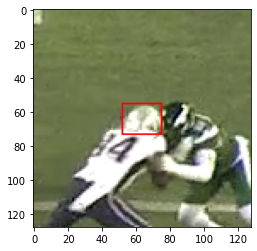

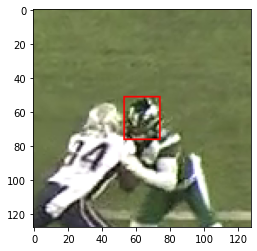

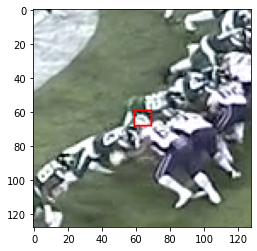

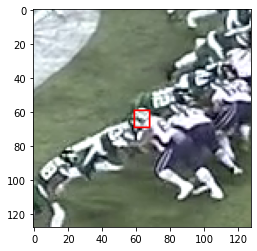

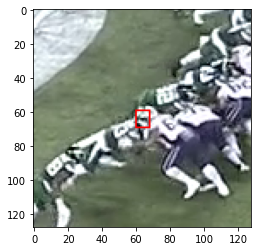

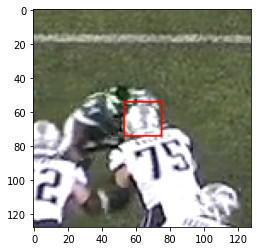

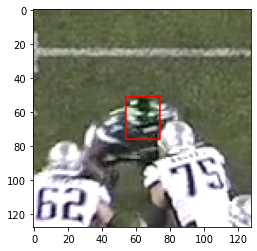

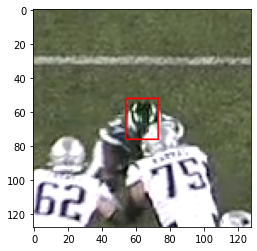

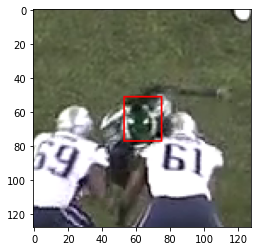

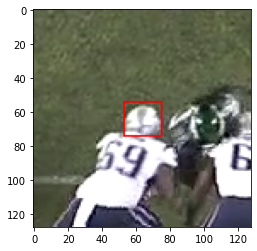

In [25]:
val_dataset = HeadClassificationDataset(positive_df, image_dir=IMAGE_DIR, img_size=IMG_SIZE, transforms=get_valid_transforms(IMG_SIZE))
val_loader = torchdata.DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=16)

cnt = 0
for i in val_loader:
    cnt += 1
    plt.imshow(i[0].numpy().transpose([1,2,0])[:,:,12:15])
    plt.show()
    if cnt == 10:
        break